**Análise Exploratório de Dados - Movielens 1M**

---

Neste Notebook você irá analisar o dataset Movilens 1M por meio de uma análise exploratória de dados. 

Metodologia:

1. Enquadrar o problema;

2. Obter os dados; // Qualidade dos dados, artigo performance similar em modelos distintos, qualidades dos dados tinha maior impacto. Problema de SmallData.

3. Descobrir e visualizar os dados para obter informações;

4. Preparar os dados para os algoritmos;

5. Selecionar e treinar modelos; // Esta e demais etapas sao realizadas pelo projeto know-rec.

6. Ajustar o modelo;

7. Apresentar sua solução;

8. Lançar, monitorar e manter seu sistema.

Neste notebook usaremos um conjunto de dados de 1.000.209 avaliações anônimas de aproximadamente 3.900 filmes feitas por 6.040  usuários que registraram-se no MovieLens no ano 2000.

# Configuração inicial

In [1]:
# Importações comuns
import numpy as np
import os
import pandas as pd # pandas is a data manipulation library
import random
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

In [2]:
#Para garantir estabilidade e ser mais fácil reproduzir experimento
np.random.seed(42)

In [3]:
# Para plotar figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

[Confira aqui](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc.html) a documentação do matplotlib.rc

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:

# Ignorar warnings desnecessários (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Enquadar o problema

- Qual o objetivo do problema?

- Como a empresa/cliente pretende usar o produto?

Tais perguntas são importantes pois definirá como você vai abordar o problema, que tipo de algoritmo irá usar e quais [medidas de desempenho](http://geam.paginas.ufsc.br/files/2020/02/Medida-desempenho-regressaob.pdf) são mais relevantes. 

// Obs. 1: Comparar interpretação geográfica de cada métrica (MAE, MSE e RMSE). Plotar as 3 retas no mesmo gráfico.

Você precisará avaliar se a solução requer uma solução muito complexa, que demandará mais trabalho, tempo e dinheiro, ou se uma solução mais simples será suficiente.

Recomendação de filmes.

1) Predizer o valor da avaliação de usuário para filme assistido.

2) Classificar se um filme será ou não assistido pelo usuário.

3) Recomendar um grupo de filmes com maior possibilidade de escolha do usuário e maior diversidade entre os filmes.

4) Modelo com maior satisfação do cliente/empresa?!

// Navalha de Okan: se você tem 2 soluções que satisfazem o problema, deve ser escolhida a mais simples. (como propor deep learning e sistemas baseados em conhecimento? Quando eles são realmente necessários?

 # Dicas

- Não aborde, em um primeiro momento, um problema usando a solução mais complexa possível. Otimização prematura é arriscado e pode comprometer o projeto;

- Leve em consideração que os modelos mais complexos são mais difíceis de manter, requer estruturas mais sofisticadas (e mais caras) e geralmente requer um corpo técnico mais qualificado - fique atento também as regulamentações dos dados;

- Comece com protótipos rápidos e vá conversando com o cliente obtendo retorno sobre as necessidades do produto. Já pensou passar meses desenvolvendo um produto e no final não era o que o cliente queria? A agilidade em fazer protótipos em Python torna essa linguagem muito interessante!

- As nossas visões, opiniões vão mudando com o tempo, então é natural que o cliente (e você!) vá amadurecendo ao longo do processo. Então, repetindo, sempre se comunique para atender a necessidade do projeto!

- Antes de começar a trabalhar no projeto, verifique todas as hipóteses do sistema, infraestrutura disponível, linguagens de programação que serão utilizada, plataformas, etc. 

# Pegar os dados

In [6]:
from zipfile import ZipFile 
from six.moves import urllib

ML1M_ROOT = "http://files.grouplens.org/datasets/movielens/"
ML1M_PATH = os.path.join("..", "..", "datasets", "ml1m")
ML1M_FILE =  "ml-1m.zip"
ML1M_MD5 = ML1M_ROOT + ML1M_FILE + ".md5"

def fetch_ml1m_data(filename=ML1M_FILE, download_root=ML1M_ROOT, save_path=ML1M_PATH):
    os.makedirs(save_path, exist_ok=True) #Cria diretorio
    file_path = os.path.join(save_path, filename) #caminho do arquivo
    download_url = os.path.join(download_root, filename) #url do arquivo
    urllib.request.urlretrieve(download_url, file_path)
    with ZipFile(file_path) as ml1m_zip:
        ml1m_zip.extractall(path=save_path)

In [7]:
fetch_ml1m_data() #Cria diretório datasets/housing no espaço de trabalho

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [8]:
# https://www.kaggle.com/cesarcf1977/movielens-data-analysis-beginner-s-first
# from http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/
def load_ml1m_data(save_path=ML1M_PATH):
    # pass in column names for each CSV
    csv_path = os.path.join(save_path, "ml-1m", "users.dat")
    u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
    users = pd.read_csv(csv_path, sep='::', engine="python", names=u_cols, encoding='utf8')

    csv_path = os.path.join(save_path, "ml-1m", "ratings.dat")
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv(csv_path, sep='::', engine="python", names=r_cols, encoding='utf8')

    # the movies file contains columns indicating the movie's genres
    # let's only load the first five columns of the file with usecols
    csv_path = os.path.join(save_path, "ml-1m", "movies.dat")
    m_cols = ['movie_id', 'title', 'genres']
    movies = pd.read_csv(csv_path, sep="::", engine="python", names=m_cols, usecols=range(5), encoding='latin-1')

    # create one merged DataFrame
    movie_ratings = pd.merge(movies, ratings)
    lens = pd.merge(movie_ratings, users)
    return users, ratings, movies, movie_ratings, lens

In [9]:
users, ratings, movies, movie_ratings, lens = load_ml1m_data()
lens.head() #visualizar as 5 primeiras linhas do dataframe

,movie_id,title,genres,user_id,rating,unix_timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


In [10]:
lens.info() #Rápida descrição dos dados

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
gender            1000209 non-null object
age               1000209 non-null int64
occupation        1000209 non-null int64
zip_code          1000209 non-null object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


As informações foram coletadas da seguinte maneira: primeiro, usou-se dados do censo de 1990 da Califórnia. Calculou-se os centróides de cada quarteirão da Califórnia, medido em latitude e longitude. *Foram excluídos todos os quarteirões que tinha entradas faltantes.*

UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
- Occupation is chosen from the following choices:
	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"
    
MovieID::Title::Genres
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

# Variáveis Categóricas

4 características são categóricas: title, genres, gender e zip_code.

In [11]:
movies["title"].value_counts()

Licence to Kill (1989)                                         1
Wild America (1997)                                            1
Two Much (1996)                                                1
For Your Eyes Only (1981)                                      1
Man Without a Face, The (1993)                                 1
Menace II Society (1993)                                       1
Character (Karakter) (1997)                                    1
Summer of Sam (1999)                                           1
My Best Fiend (Mein liebster Feind) (1999)                     1
Babysitter, The (1995)                                         1
Never Talk to Strangers (1995)                                 1
Celestial Clockwork (1994)                                     1
Anna (1996)                                                    1
Conspiracy Theory (1997)                                       1
Education of Little Tree, The (1997)                           1
Paradise Lost: The Child 

Cada um dos 3883 filmes possui um título distinto. 

In [12]:
movies["genres"].value_counts()

Drama                                            843
Comedy                                           521
Horror                                           178
Comedy|Drama                                     162
Comedy|Romance                                   142
Drama|Romance                                    134
Documentary                                      116
Thriller                                         101
Action                                            65
Drama|Thriller                                    63
Action|Thriller                                   48
Children's|Comedy                                 47
Crime|Drama                                       44
Drama|War                                         43
Romance                                           40
Action|Drama                                      39
Animation|Children's                              35
Comedy|Drama|Romance                              34
Western                                       

Como podemos observar, a característica "genres" é uma variável multivalorada, com 301 combinações de 18 gêneros de filmes. Podemos analisar desta forma (nome bonito que não lembro que define clases que significam combinações de classes menores) ou tratar os 18 generos como OneHotEncoder (ver se dá de usar esse).

From https://www.kaggle.com/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis

In [13]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [14]:
#here we  make census of the genres:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [15]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Western', 68],
 ['Fantasy', 68],
 ['Film-Noir', 44]]

"OneHotEncode" para genres:

In [16]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later

In [17]:
new_movies = movies.join(movies.genres.str.get_dummies())
new_movies.drop('genres', inplace=True, axis=1)

In [18]:
new_movies.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
new_movies.describe()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1986.049446,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,1146.778349,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,982.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2980.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
users["gender"].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [21]:
users["zip_code"].value_counts()

48104         19
22903         18
94110         17
55104         17
55105         16
10025         16
55455         16
94114         15
55408         15
02138         15
90024         14
94117         14
98103         14
37922         13
10016         13
90210         13
60640         13
48103         13
55406         12
02139         11
55405         11
48105         11
55113         11
10003         11
55112         10
10021         10
02143         10
98115         10
97330         10
10011         10
              ..
02113          1
21045          1
89193          1
63135          1
23456          1
27708          1
87020          1
95124          1
89511          1
30052          1
11753          1
92278          1
48371          1
49686          1
02725-1010     1
91428          1
02150          1
02718          1
81007          1
89103          1
98055          1
30501          1
32303          1
53523          1
62629          1
55313          1
27203          1
45678         

# Variáveis Numéricas

In [22]:
users.describe() #Medidas resumo

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [23]:
ratings.describe() #Medidas resumo

,user_id,movie_id,rating,unix_timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [24]:
movies.describe() #Medidas resumo

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


# Histogramas

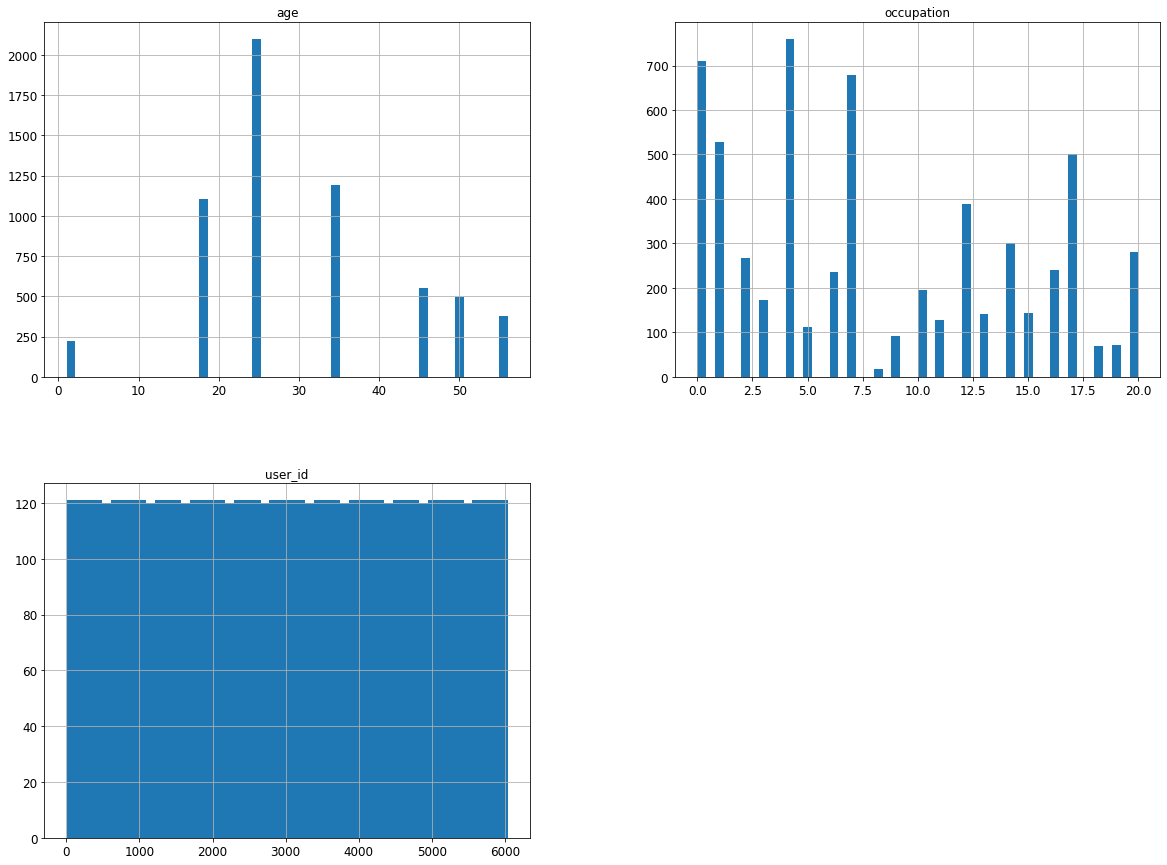

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
users.hist(bins=50, figsize=(20,15))
plt.show()

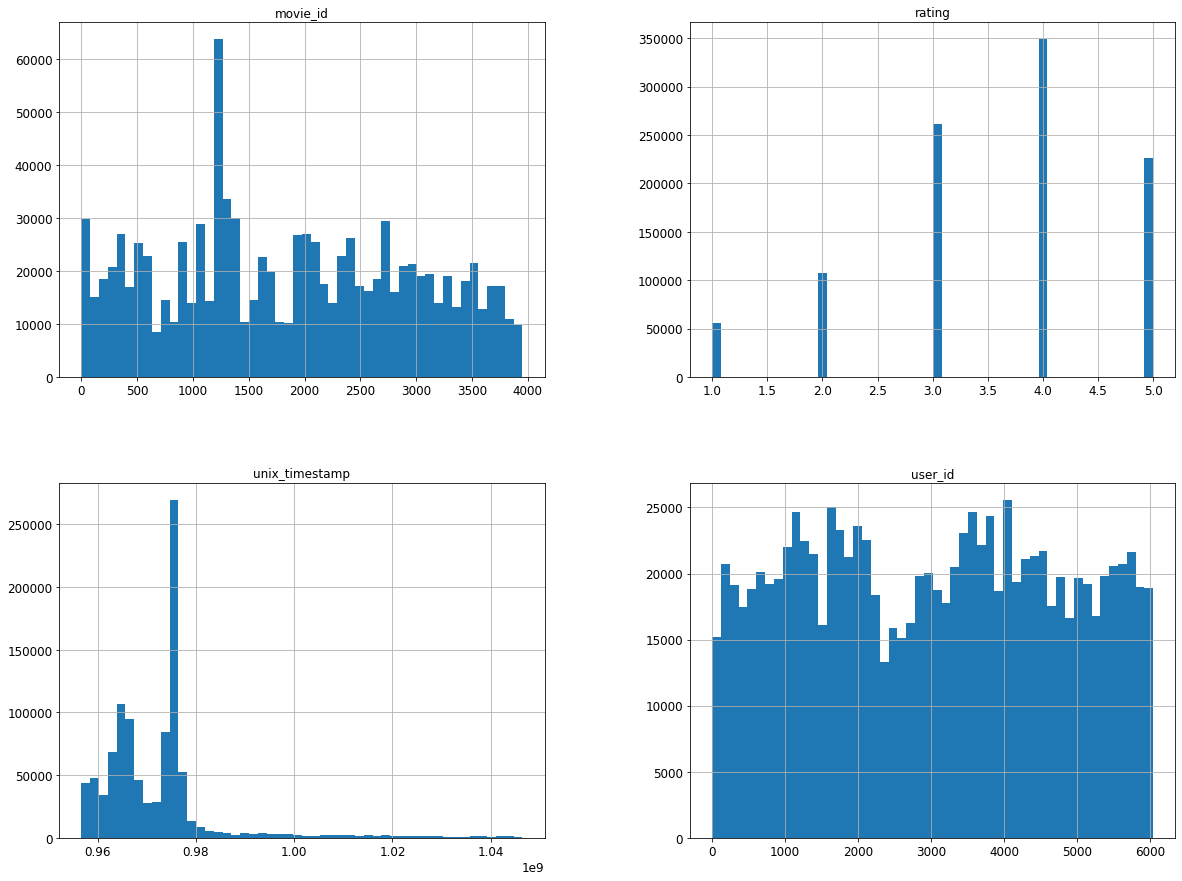

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
ratings.hist(bins=50, figsize=(20,15))
plt.show()

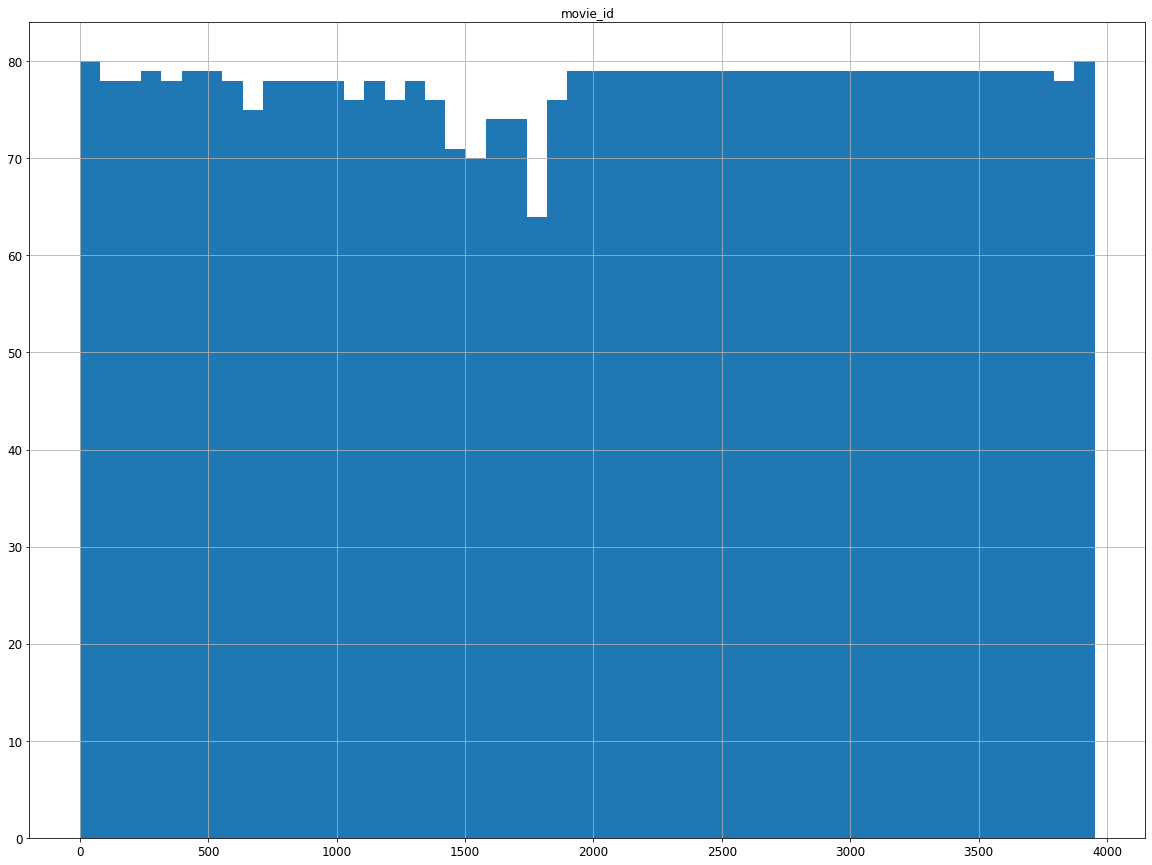

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
movies.hist(bins=50, figsize=(20,15))
plt.show()

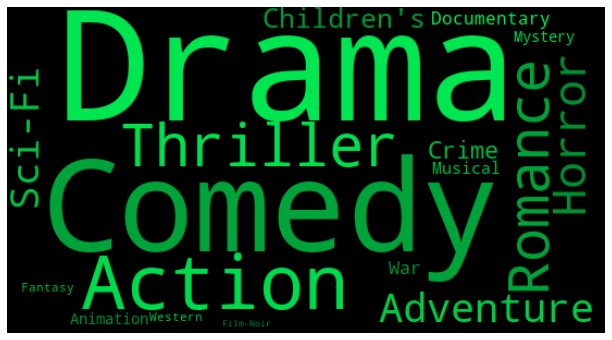

In [28]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

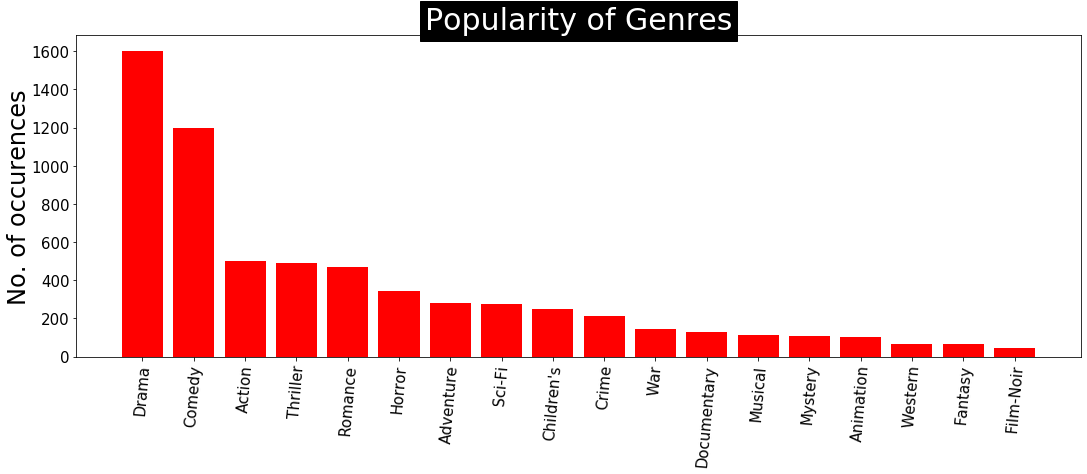

In [29]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

# Limpeza

In [30]:
#is any row null
users.isnull().any()

user_id       False
gender        False
age           False
occupation    False
zip_code      False
dtype: bool

In [31]:
#is any row null
movies.isnull().any()

movie_id    False
title       False
genres      False
dtype: bool

In [32]:
#is any row null
ratings.isnull().any()

user_id           False
movie_id          False
rating            False
unix_timestamp    False
dtype: bool

# Separando o conjunto de dados

Estratificação dos ratings, pois é importante ter um número suficiente de instâncias para cada estrato no conjunto de dados (treino e testes), do contrário pode ser que os nossos dados fiquem enviasados.

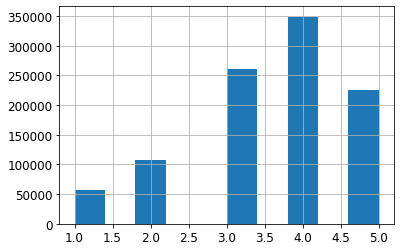

In [33]:
ratings["rating"].hist()

Pronto! Agora vamos fazer uma <font color='red'>amostragem estratificada</font> com base nas categorias da renda.  

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Acabamos de criar novos conjuntos de treino e de teste, que chamamos de <font color='red'>strat_train_set </font> e <font color='blue'>strat_test_set</font>.

 Estes conjuntos devem respeitar a estratificação que introduzimos baseada em "median_income" representado na nova variável categórica "income_cat".

 Vejamos se funcionou:

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set) #Proporção de cada categoria em strat_test_set

In [ ]:
housing["income_cat"].value_counts() / len(housing) #Proporção de cada categoria em housing

Podemos agora comparar com a <font color='blue'> amostragem aleatória </font>:

In [ ]:
#Função para calcular as proporções das categorias da característica "income_cat"
def income_cat_proportions(data): 
    return data["income_cat"].value_counts() / len(data)

Agora vamos gerar novamente conjunto de teste e treino, mas usando amostragem aleatória.

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Vamos criar o nosso novo dataframe e visualizar os resultados:

In [ ]:
compare_props = pd.DataFrame({
    "Geral": income_cat_proportions(housing),
    "Estratificado": income_cat_proportions(strat_test_set),
    "Aleatorio": income_cat_proportions(test_set),
}).sort_index()

compare_props["Aleatório %erro"] = 100 * compare_props["Aleatorio"] / compare_props["Geral"] - 100
compare_props["Estratificado %erro"] = 100 * compare_props["Estratificado"] / compare_props["Geral"] - 100

compare_props

Contentes com os resultados, não podemos esquecer de <font color='red'>remover</font> o atributo "income_cat" dos conjuntos strat_train_set e strat_test_set. Na verdade, ele era apenas um intermediário, afinal de contas as informações dessa caracaterísticas já estão presentes em "median_income".

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Visualização da estrutura de dados

Vamos agora visualizar os nossos dados. Precisamos ter certeza que não vamos visualizar dados do conjunto de teste, para evitar enviesamento de conclusões.

In [ ]:
housing = strat_train_set.copy() #Importante criar uma cópia! 

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Vamos melhorar a visualição usando o parâmetro <font color='red'>alpha</font>, observe:

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Interessante! Agora fica mais evidente a concentração dos agrupamentos!

De qualquer forma devemos voltar a nossa atenção ao objetivo: <font color = 'red'> preços do setor imobioliário. </font> 

No código a seguir o parâmetro "s" significa "size", tamanho em inglês. Escolhendo "s" como sendo a característica população, quanto maior o disco representa uma população maior.

O parâmetro "c" significa "color", ou cor. Esse é na verdade o que queremos saber!

O paramêtro colorbar = True indica que queremos visualizar a barra lateral informando as intensidades da cor, ou seja, do parêmetro "c".



In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False) #sharex=false é só pra corrigir um bug de display https://github.com/pandas-dev/pandas/issues/10611
plt.legend()

A visulização dos dados indicam que regiões litorâneas tendem a possuir um valor mais alto. Talevz a densidade populacional também possa ser algo relevante.

Vamos então investigar essas hipóteses através da correleção estatística:

In [ ]:
corr_matrix = housing.corr() #Matriz de correlações

In [ ]:
corr_matrix #vamos ver a estrutura

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False) #Ordenar valores em sentido decrescente

É conveniente usar o scatter_matrix do pandas. Essa função plota cada característica em relação a outra. No nosso exemplo, teríamos 121 possibilidades.

Vamos aproveitar e ver alguns [conceitos básicos de estatística](http://geam.paginas.ufsc.br/files/2020/02/Estatistica_Basica.pdf).

Mas claro que não faremos isso e vamos então selecionar algumas que parecem ser mais significativas:

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

OBS: Na diagonal principal da plotagem anterior não temos atributo x atributo, mas sim o histograma da característica.

Vimos antes, que a característica que tinha maior correleção com o valor mediano de casas em um bairro era o salário mediano. Então vamos plotar para estudar a relação entre ambos:

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Informações desta plotagem: 

1) Correlação é forte;

2) Há um valor limiar de 500.000 para os valores (medianos) das casas. Por quê?

3) Há também outras linhas horizontais. Por que elas são importantes?

Uma abordagem possível seria excluir os dados correspondentes a esses casos.

# Feature Engineering

Além das colunas que o conjunto de dados nos oferece, podemos tentar construir novas características <font color = "red">construídas de maneiras não linear</font> com as características existentes.

De maneira geral, essa etapa requer conhecimento específico da área na qual se esta trabalhando. Daí a importância da presença de um especialista no assunto para auxiliar no projeto. 

A seguir, vamos construir algumas novas features que são mais ou menos lógicas.

In [ ]:
#Nova feature: Número de cômodos por familia (média)
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

#Nova feature: quartos/cômodos
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

#Nova feature: população/agregado familiar
housing["population_per_household"]=housing["population"]/housing["households"]

Vejamos agora a matriz de correlação de housing:

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

Aparentemente, casas com uma baixa proporção de quartos para cômodas tendem a ser mais caras. O número de cômodos por família é muito mais informartivo que o número total de quartos em um quarteirão.

Vejamos o gráfico:

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

Vamos ver novamente as medidas resumos considerando as novas features!

In [ ]:
housing.describe()

# Preparar os dados para os algoritmos de Machine Learning

Precisamos incialmente retirar os rótulos do conjunto <fon color='blue'> strat_train_set </font> (mais a frente ficará claro).

Para isso, vamos usar o método drop:

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # O método drop cria cópia sem a coluna em questao
housing_labels = strat_train_set["median_house_value"].copy() #salvando uma cópia

A partir de agora vamos partir para etapa de <font color='blue'>limpeza de dados!</font>

Vamos começar verificandi se temos dados falantes:

In [ ]:
#housing.isnull().any(axis=1) verifica quais linhas possuem alguma célula null
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

Possuímos basicamente três abordagens possíveis para lidar com os dados faltantes:

1. Excluir os quarteirões com dados faltantes;

2. Excluir toda coluna de total_bedrooms, já que é o único atributo que apresenta dados faltantes;

3. Definir algum valor para substituir total_bedrooms.

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # opção 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # opção 2

Opção 3: preenchendo com algum valor - nesse caso, usaremos a mediana.

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # opção 3
sample_incomplete_rows

Se escolhermos a opção 3, devemos calular a mediana (ou qualquer outra medida que seja justificável) no <font color="red">conjunto de treinamento</font> e usá-lo para preencher os valores faltantes neste, mas precisamos <font color="blue">salvar</font> esse valor cálculado.

Você precisar desse valor para mais tarde aplicar no conjunto de teste, que deverá ter seus dados faltantes corrigidos seguindo o mesmo parâmetro do conjunto de treino.

**AVISO**: No Scikit-Learn 0.20, a classe `sklearn.preprocessing.Imputer` 
foi substituida pela classe `sklearn.impute.SimpleImputer`. Então, é conviniente verificar qual versão o computador em questão está usando:

In [ ]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
    print("Scikit-Learn 0.20+")
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    print("Scikit-Learn antes do 0.20")

imputer = SimpleImputer(strategy="median")

Vamos novamente revisar o nosso dataset...

In [ ]:
housing

Ainda temos a última coluna que não é numérica! 

A princípios, grande parte dos algoritmos de machine learning no computador preferem os dados representados numericamente!

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)
# Derrubando a coluna "ocean_proximity"
# alternativa: housing_num = housing.select_dtypes(include=[np.number])

Agora vamos ajudar o nosso objeto imputer com o nossos dados:

In [ ]:
imputer.fit(housing_num) 

Aqui, o imputer simplesmente calculou a mediana no conjunto de dados.

Vejamos algumas informações sobre o nosso objeto imputer:

In [ ]:
imputer.statistics_

Vamos verificar que isto é, na verdade, a mesma coisa que calcular manualmente a mediana de cada atributo:

In [ ]:
housing_num.median().values

Mas não seria apenas o atributo "total_bedrooms" que estava com valores faltantes? 

Vamos precisar de todas as informações do imputer? Isto é, vamos precisar da mediana de todas as variáveis?

<font color='red'> Não podemos, a princípio, afirmar que o mesmo padrão vai ser repetir na generalização do modelo! </font>

Certo, mas e se dermos uma espiadinha no conjunto de testes?

Não devemos fazer isso por vários motivos. 

1. Corremos o risco de colocar vieses no nosso modelo (assumir que apenas "total_bedrooms" terá colunas com dados faltantes em todos os cenários possíveis é um deles;

2. Devemos ter sempre em mente que o conjunto de teste é no fundo uma simulação para testarmos o poder de generalização do algoritmo - devemos fazer todas as nossas análises e otimizações somente no conjunto de treinamento e então aplicar o modelo final uma única vez no conjunto de teste!



Vamos agora finalmente <font color = 'blue'> transformar </font> o nosso conjunto de dados, aplicando, efetivamente, o valor calculado da mediana nos dados faltantes:

In [ ]:
X = imputer.transform(housing_num) #numpy array

Vamos visualizar o conjunto X

In [ ]:
X

Se você se sentir mais confortável, pode transformar o conjunto X em um dataframe:

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, #importante informar nome das colunas
                          index=housing.index) #DataFrame Pandas

Vejamos como é este dataframe:

In [ ]:
housing_tr.head()

Agora devemos tratar a variável categórica`ocean_proximity'!

Lembre que esta é uma variável muito importante no nosso problema: ela demonstrava uma boa correlação com o preço mediano das casas.

Vamos novamente visualizar os dados para relembrar:

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

Agora vamos usar um processo chamado de codificação. Vamos transformar as nossas variáveis categóricas em números!

**OBS**: O código a seguir é apenas devido a atualização da classe OriginalEnconder()

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder
    print("Scikit-Learn >= 2.0")
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20
    print("O teu Scikit-Learn tá antiguinho mô quirido")

Na função a seguir, precisamos instanciar um objeto ordinal_encoder. 

Depois, usamos fit_transform para executa duas operações:

1. Método fit irá ajustar os parâmetros (mapeamento, por exemplo, quais são as variáveis categóricas); 

2. Método transform irá transformar os dados;

3. fit_transform(dados) irá ajustar parâmetros e transformar os dados.


In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

Uma alternativa mais prolixa teria sido escrever:

original_encoder.fit(housing_cat)

housing_cat_encoded = original_enconder.fit(housing_cat)


Vejamos que tipo de objeto é housing_cat_encoded:

In [ ]:
type(housing_cat_encoded)

Vamos ver agora os 10 primeiros valores desse numpy array:

In [ ]:
housing_cat_encoded[:10]

Vamos relembrar também as categorias do nosso problema:

In [ ]:
ordinal_encoder.categories_

Veja! 

O objeto ordinal_encoder foi construiído assim:

ordinal_encoder = OrdinalEncoder() 

e depois fizemos o seguinte:

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

<font color = "red">Aqui não apenas definimos quem é "housing_cat_encoded" como também inserimos informações no objeto ordinal_encoder! </font>

Apesar dos nossos esforços, temos um grave problema na nossa codificação, veja novamente: 

In [ ]:
housing_cat_encoded[:10]

In [ ]:
housing_cat[:10]

Cada variável categórica foi transformada em número!

Mas será que a princípio, podemos comparar uma variável categórica com outra?

Quem é maior: NEAR OCEAN ou NEAR BAY? 

Bem, é difícil responder. Mas é isso que a nossa codificação implicítacamente está fazendo ao colocar os valores 0,1,2,3 ou 4 para cada variável categórica. 

<font color="red"> Para lidar com essa situação precisamos então de outra abordagem!</font>

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # gera um ImportError se Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

Epa! Agora temos uma matriz SciPy ao invés de um Numpy array! 

<font color = "red">Por que será?</font>

In [ ]:
housing_cat_1hot.toarray()

Temos agora uma matriz esparsa! (mais econômica computacionalmente)

Alternativamente, podemos colocar `sparse=False` ao criar o objeto `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

Let's create a custom transformer to add extra attributes:

Vamos criar um transformador customizado para adicionar atributos extras 

**OBS**: aqui vamos simplesmente criar um código para o processo manual feito na etapa de Feature Engineering. Vai nos ajudar a criar um pipeline mais a frente.

In [ ]:
housing.columns

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Buscando os indices corretos das colunas: 
# Mais seeguro que ficar digitando 3, 4, 5, 6..
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # Nada a fazer!
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternativamente, você pode usar a função da classe `FunctionTransformer` que permite você criar rapidamente um transformador baseado em uma função de transformação! 

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})

housing_extra_attribs = attr_adder.fit_transform(housing.values)

#Vale a pena colocar validate=False já queos dados não possuem valores não-float
#validate=false é valor padrão a partir do Scikit-Learn 0.22.

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

Agora vamos construir um "pipeline" (tradução literal: gasoduto) para pré-processar os atributos numéricos - obser que poderíamos usar <font color = 'blue'> CombinedAttributesAdder()</font>
ao invés do <font color = 'blue'> FunctionTransformer(...) </font>, se quiséssemos:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
#StandardScaler serve para fazer a reescalar das variáveis

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

Agora finalmente temos os nossos dados pré-processados! 

# Selecionar e treinar um modelo

Vamos começar com um modelo siples: Regressão Linear!

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) 
#Ei Regressão linear, encontre os parâmetros que melhor aproxima os dados

Vamos agora testar o nosso pipeline de pré-processamento em algumas instâncias de treino.

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) 

print("Predictions:", lin_reg.predict(some_data_prepared))

Vamos comparar agora com os valores reais:


In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

Agora vamos usar as métricas que aprendemos anteriormente!

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = MSE(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) #Não é necessariamente obrigatório
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE

lin_mae = MAE(housing_labels, housing_predictions)
lin_mae

Essse modelo ainda não parece ser adequado!

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = MSE(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

O quê? Erro zero?

#Vamos continuar na próxima aula a calibrar esse modelo!